In [1]:
import pyvisa
import matplotlib.pyplot as plt
import numpy as np
import srlock
import time
from scipy.optimize import curve_fit


In [2]:
rm = pyvisa.ResourceManager()

rm.list_resources()

('GPIB0::8::INSTR',)

In [3]:
%%time
res = "GPIB0::8::INSTR"

with srlock.SR830(resource=res, timeout=10000) as lia:
    print("IDN:", lia.idn())  # IDN?
    lia.outx(1)  # ensure responses to GPIB
    print("Current phase (deg):", lia.phas())  # PHAS?
    lia.fmod(1)  # internal reference
    print("Freq set, read back:", lia.freq())
    lia.slvl(2.4)
    print(lia.slvl())


IDN: Stanford_Research_Systems,SR830,s/n46821,ver1.07
Current phase (deg): 41.25
Freq set, read back: 5.0
2.4
CPU times: total: 15.6 ms
Wall time: 184 ms


In [105]:
res = "GPIB0::8::INSTR"
filename_attr = ""
last_filename = ""

base = 1.5
# Starting data collection
freqRange = [i for i in range(20_000, 100_000, 2000)]
# freqRange = [np.floor((base)**i) for i in range(15, int(np.log(100_000)/np.log(base)) + 1)]
freqRange.append(100_000)
# voltRange = [i / 10 for i in range(0, 50)]
voltRange = [1e-2]
R0 = 2200

# Data collection
data = np.zeros((len(freqRange), len(voltRange), 4))
noise = np.zeros((len(freqRange), len(voltRange), 4))

# Config
run = 15
timeConst = 0.1  # in seconds


In [106]:
freqRange, len(freqRange)

([20000,
  22000,
  24000,
  26000,
  28000,
  30000,
  32000,
  34000,
  36000,
  38000,
  40000,
  42000,
  44000,
  46000,
  48000,
  50000,
  52000,
  54000,
  56000,
  58000,
  60000,
  62000,
  64000,
  66000,
  68000,
  70000,
  72000,
  74000,
  76000,
  78000,
  80000,
  82000,
  84000,
  86000,
  88000,
  90000,
  92000,
  94000,
  96000,
  98000,
  100000],
 41)

In [107]:
%%time
with srlock.SR830(resource=res, timeout=10000) as lia:
    global filename_attr, freqRange, voltRange, data, noise, run, timeConst
    print("IDN:", lia.idn())  # IDN?
    lia.outx(1)  # ensure responses to GPIB
    print("Current phase (deg):", lia.phas())  # PHAS?
    lia.fmod(1)  # internal reference
    print("Freq set, read back:", lia.freq())
    lia.oflt(8)
    # lia.sens(21)
    # lia.aphs()
    # time.sleep(30)
    time.sleep(timeConst)

    for i in range(len(freqRange)):
        for j in range(len(voltRange)):
            print(j)
            try:
                lia.slvl(voltRange[j])
                # if (j == 0):
                #     lia.agan()
                #     time.sleep(30*timeConst)
                lia.freq(freqRange[i])
                # lia.aphs()
                # time.sleep(3*timeConst)
                #lia.agan()
                #time.sleep(3*timeConst)
                print("Frequency:", freqRange[i], "Voltage:", voltRange[j])
                time.sleep(30*timeConst)
                # Poll for values
                runData = np.zeros((run, 4))
                for o in range(run):
                    snap_vals = lia.snap([1, 2, 3, 4])
                    print(snap_vals)
                    runData[o, 0] = snap_vals[0]
                    runData[o, 1] = snap_vals[1]
                    runData[o, 2] = snap_vals[2]
                    runData[o, 3] = snap_vals[3]
                    time.sleep(5*timeConst)
                m = np.mean(runData, axis=0)
                n = np.std(runData, axis=0)
                data[i, j] = m
                noise[i, j] = n
            except Exception as e:
                print(f"{e} DETECTED. SAVING PARTIAL DATA.")
                filename_attr = "incomplete"
                break


# Save data
last_filename = f"johnson_act_noise_data_{time.time():.0f}.npz"
np.savez(last_filename, freqRange=freqRange, voltRange=voltRange, data=data, noise=noise)
# change sync_filtero_act_noise_data_1762513140 to johnson1k_act_noise_data_1762513140

IDN: Stanford_Research_Systems,SR830,s/n46821,ver1.07
Current phase (deg): 41.25
Freq set, read back: 100000.0
0
Frequency: 20000 Voltage: 0.01
[7.45064e-09, 4.28411e-08, 4.28411e-08, 79.116]
[2.04892e-08, 0.0, 2.04892e-08, 4.398]
[3.91158e-08, 9.31328e-09, 4.09784e-08, 14.034]
[-3.72531e-08, 1.30386e-08, 3.72531e-08, 160.02]
[7.63689e-08, 3.53905e-08, 8.38195e-08, 25.56]
[-5.96051e-08, -2.42145e-08, 6.33304e-08, -158.196]
[8.75448e-08, 7.63689e-08, 1.15484e-07, 40.956]
[-5.21543e-08, -6.5193e-08, 8.19568e-08, -128.478]
[6.5193e-08, 9.6858e-08, 1.17347e-07, 55.866]
[-2.79398e-08, -8.56821e-08, 8.75448e-08, -107.418]
[4.8429e-08, 1.11759e-07, 1.22935e-07, 66.192]
[7.45064e-09, -9.87206e-08, 9.6858e-08, -85.158]
[0.0, 1.1921e-07, 1.1921e-07, 90.0]
[8.56821e-08, -8.00942e-08, 1.17347e-07, -42.708]
[-4.28411e-08, 7.26436e-08, 8.38195e-08, 119.604]
0
Frequency: 22000 Voltage: 0.01
[2.04892e-08, 1.49013e-08, 2.60771e-08, 34.698]
[2.04892e-08, 1.49013e-08, 2.60771e-08, 34.698]
[1.30386e-08, 1

In [108]:
data.shape

(41, 1, 4)

In [109]:
loaded_data = np.load(last_filename)
# loaded_data = np.load("noise_data_1762507995.npz")
# data_1762427561.npz

In [110]:
X = loaded_data["data"][:, :, 0]
Y = loaded_data["data"][:, :, 1]
R = loaded_data["data"][:, :, 2]
Theta = loaded_data["data"][:, :, 3]
freqRange_coll = loaded_data["freqRange"][:]
noise_coll = loaded_data["noise"]
Resistance = 1e3 * R0 * R / voltRange[0]
ResistanceX = 1e3 * R0 * X / voltRange[0]

In [111]:
X

array([[1.45287120e-08],
       [1.53979613e-08],
       [2.01166800e-08],
       [2.11101067e-08],
       [1.51496120e-08],
       [2.86849133e-08],
       [2.43387267e-08],
       [3.57629800e-08],
       [3.61355253e-08],
       [3.55146400e-08],
       [3.50179200e-08],
       [3.92399533e-08],
       [3.88674067e-08],
       [4.14751133e-08],
       [3.50179160e-08],
       [4.84290267e-08],
       [5.65005133e-08],
       [4.34619760e-08],
       [5.40170200e-08],
       [6.37028333e-08],
       [5.92324867e-08],
       [6.66831200e-08],
       [5.96050000e-08],
       [9.44986947e-08],
       [7.57480107e-08],
       [6.85458067e-08],
       [7.81073867e-08],
       [8.15843267e-08],
       [8.05909200e-08],
       [8.53096067e-08],
       [8.79173267e-08],
       [9.06491533e-08],
       [8.81656600e-08],
       [9.37535800e-08],
       [9.18909333e-08],
       [9.97140067e-08],
       [9.80997333e-08],
       [9.94656867e-08],
       [1.04681200e-07],
       [9.98382400e-08],


In [112]:
noiseX = np.asarray(loaded_data["noise"][:, :, 0].flatten())
noiseR = loaded_data["noise"][:, :, 2].flatten()
noiseY = loaded_data["noise"][:, :, 1].flatten()
noiseTheta = loaded_data["noise"][:, :, 3].flatten()

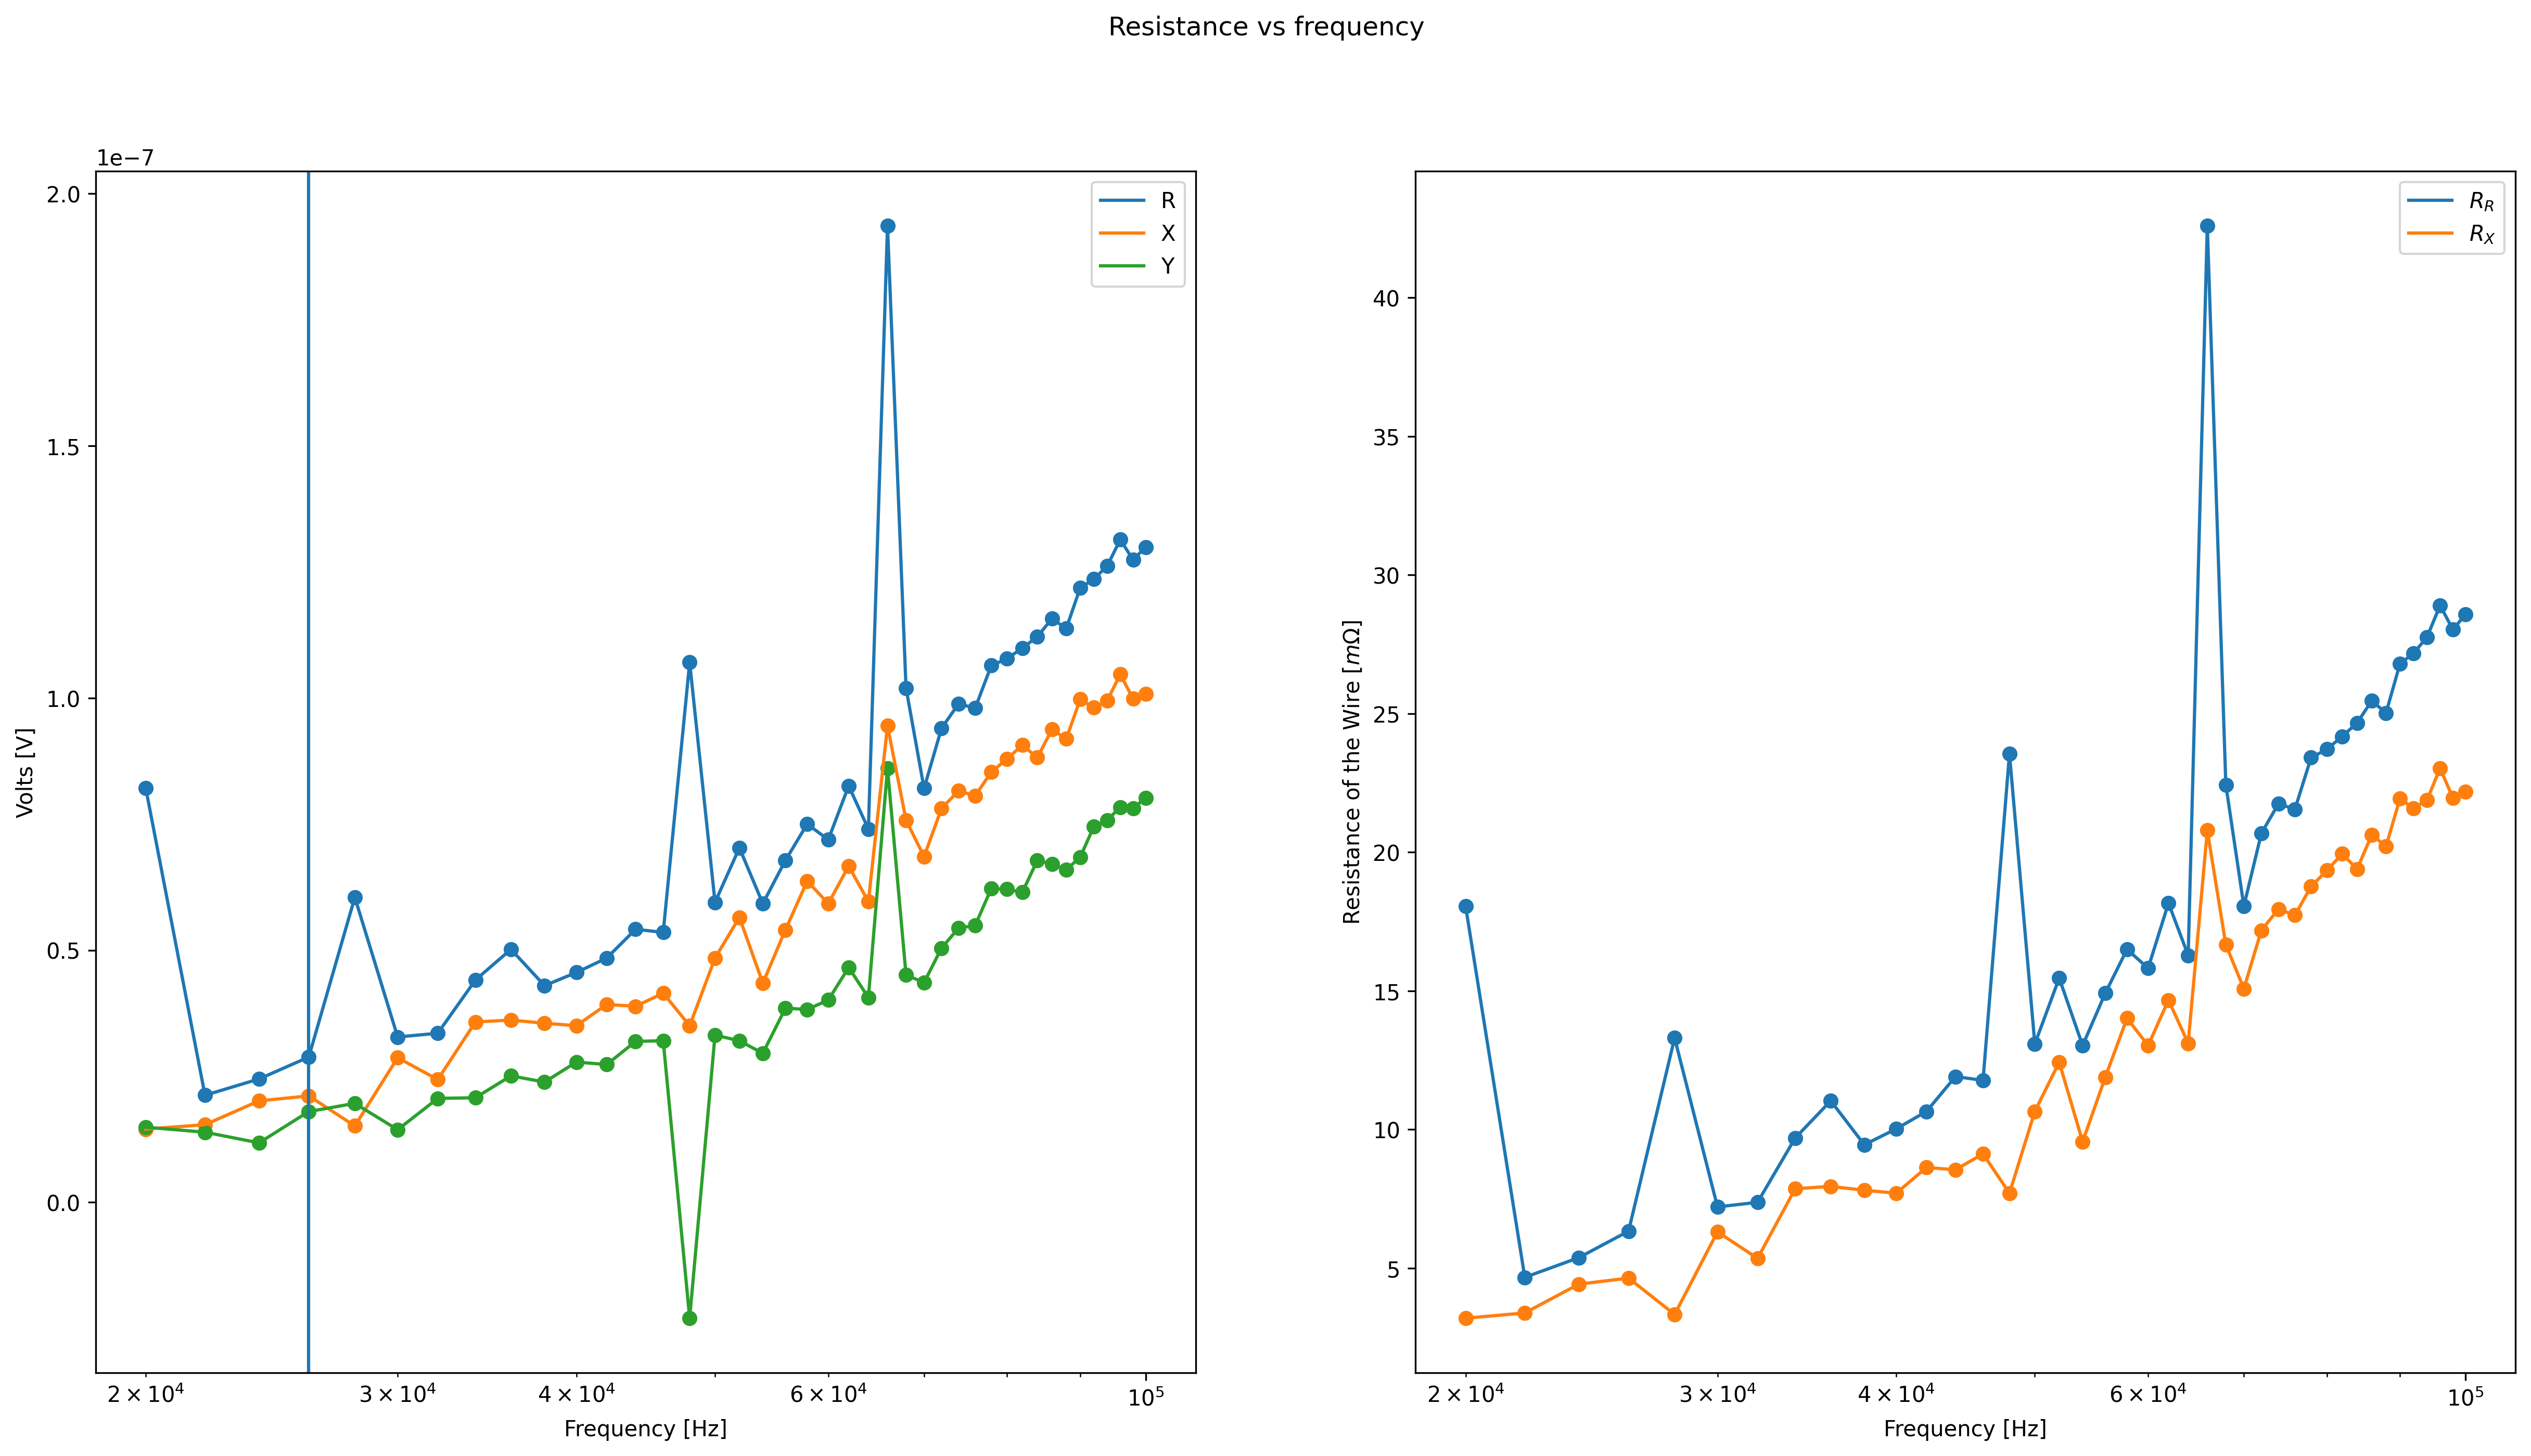

In [113]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(20,10))
ax = axes[0]
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Volts [V]")
ax.set_xscale("log")
ax.scatter(freqRange_coll, R)
ax.scatter(freqRange_coll, X)
ax.scatter(freqRange_coll, Y)
ax.plot(freqRange_coll, R, label="R")
ax.plot(freqRange_coll, X, label="X")
ax.plot(freqRange_coll, Y, label="Y")
ax.axvline(freqRange[3])
# ax.plot(freqRange_coll, Theta, label="Y")
# ax.errorbar(freqRange_coll, R, yerr=noiseR)
ax.legend()
ax = axes[1]
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Resistance of the Wire [$m\Omega$]")
ax.plot(freqRange_coll, Resistance, label="$R_R$")
ax.plot(freqRange_coll, ResistanceX, label="$R_X$")
ax.scatter(freqRange_coll, Resistance)
ax.scatter(freqRange_coll, ResistanceX)
ax.set_xscale("log")
fig.suptitle("Resistance vs frequency")
ax.legend()
# fig.savefig("Res_vs_freq_base1pt5.png", dpi=300)

In [96]:
ResistanceX, freqRange[4]

(array([[ 3.08704352],
        [ 0.24587053],
        [ 1.52986005],
        [ 0.68297533],
        [ 2.32211115],
        [ 2.75921712],
        [ 3.90661216],
        [ 6.55655147],
        [14.4517296 ],
        [ 6.72046467],
        [11.88373853],
        [18.7954316 ],
        [29.641084  ],
        [43.79221733],
        [50.102888  ]]),
 np.float64(2216.0))

In [116]:
def linfit(x,a,b):
    y = a*x+b
    return y
def logfit(x,a,b,c):
    y = a/(np.pow(x,b))
    y = y+c
    return y
xf = np.log(freqRange_coll[:fc_cutoff])
yf = np.log((noiseX**2)[:fc_cutoff])

xf1 = freqRange_coll[:fc_cutoff]
yf1 = (noiseX**2)[:fc_cutoff]


params, pcov = curve_fit(linfit, xf,yf)
params1, pcov1 = curve_fit(logfit, xf1,yf1, p0 = [0,2,0], maxfev = 10000)
perr = np.sqrt(np.diag(pcov))
perr1 = np.sqrt(np.diag(pcov1))

params, perr,params1, perr1

C:\Users\iamsa\AppData\Local\Temp\ipykernel_14712\2947969313.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params1, pcov1 = curve_fit(logfit, xf1,yf1, p0 = [0,2,0], maxfev = 10000)


(array([ -0.5576589 , -30.76794451]),
 array([0.58032216, 6.32790593]),
 array([-6.36501011e-08,  2.00000000e+00,  7.98672382e-16]),
 array([inf, inf, inf]))

Text(0, 0.5, 'Noise(log scale)')

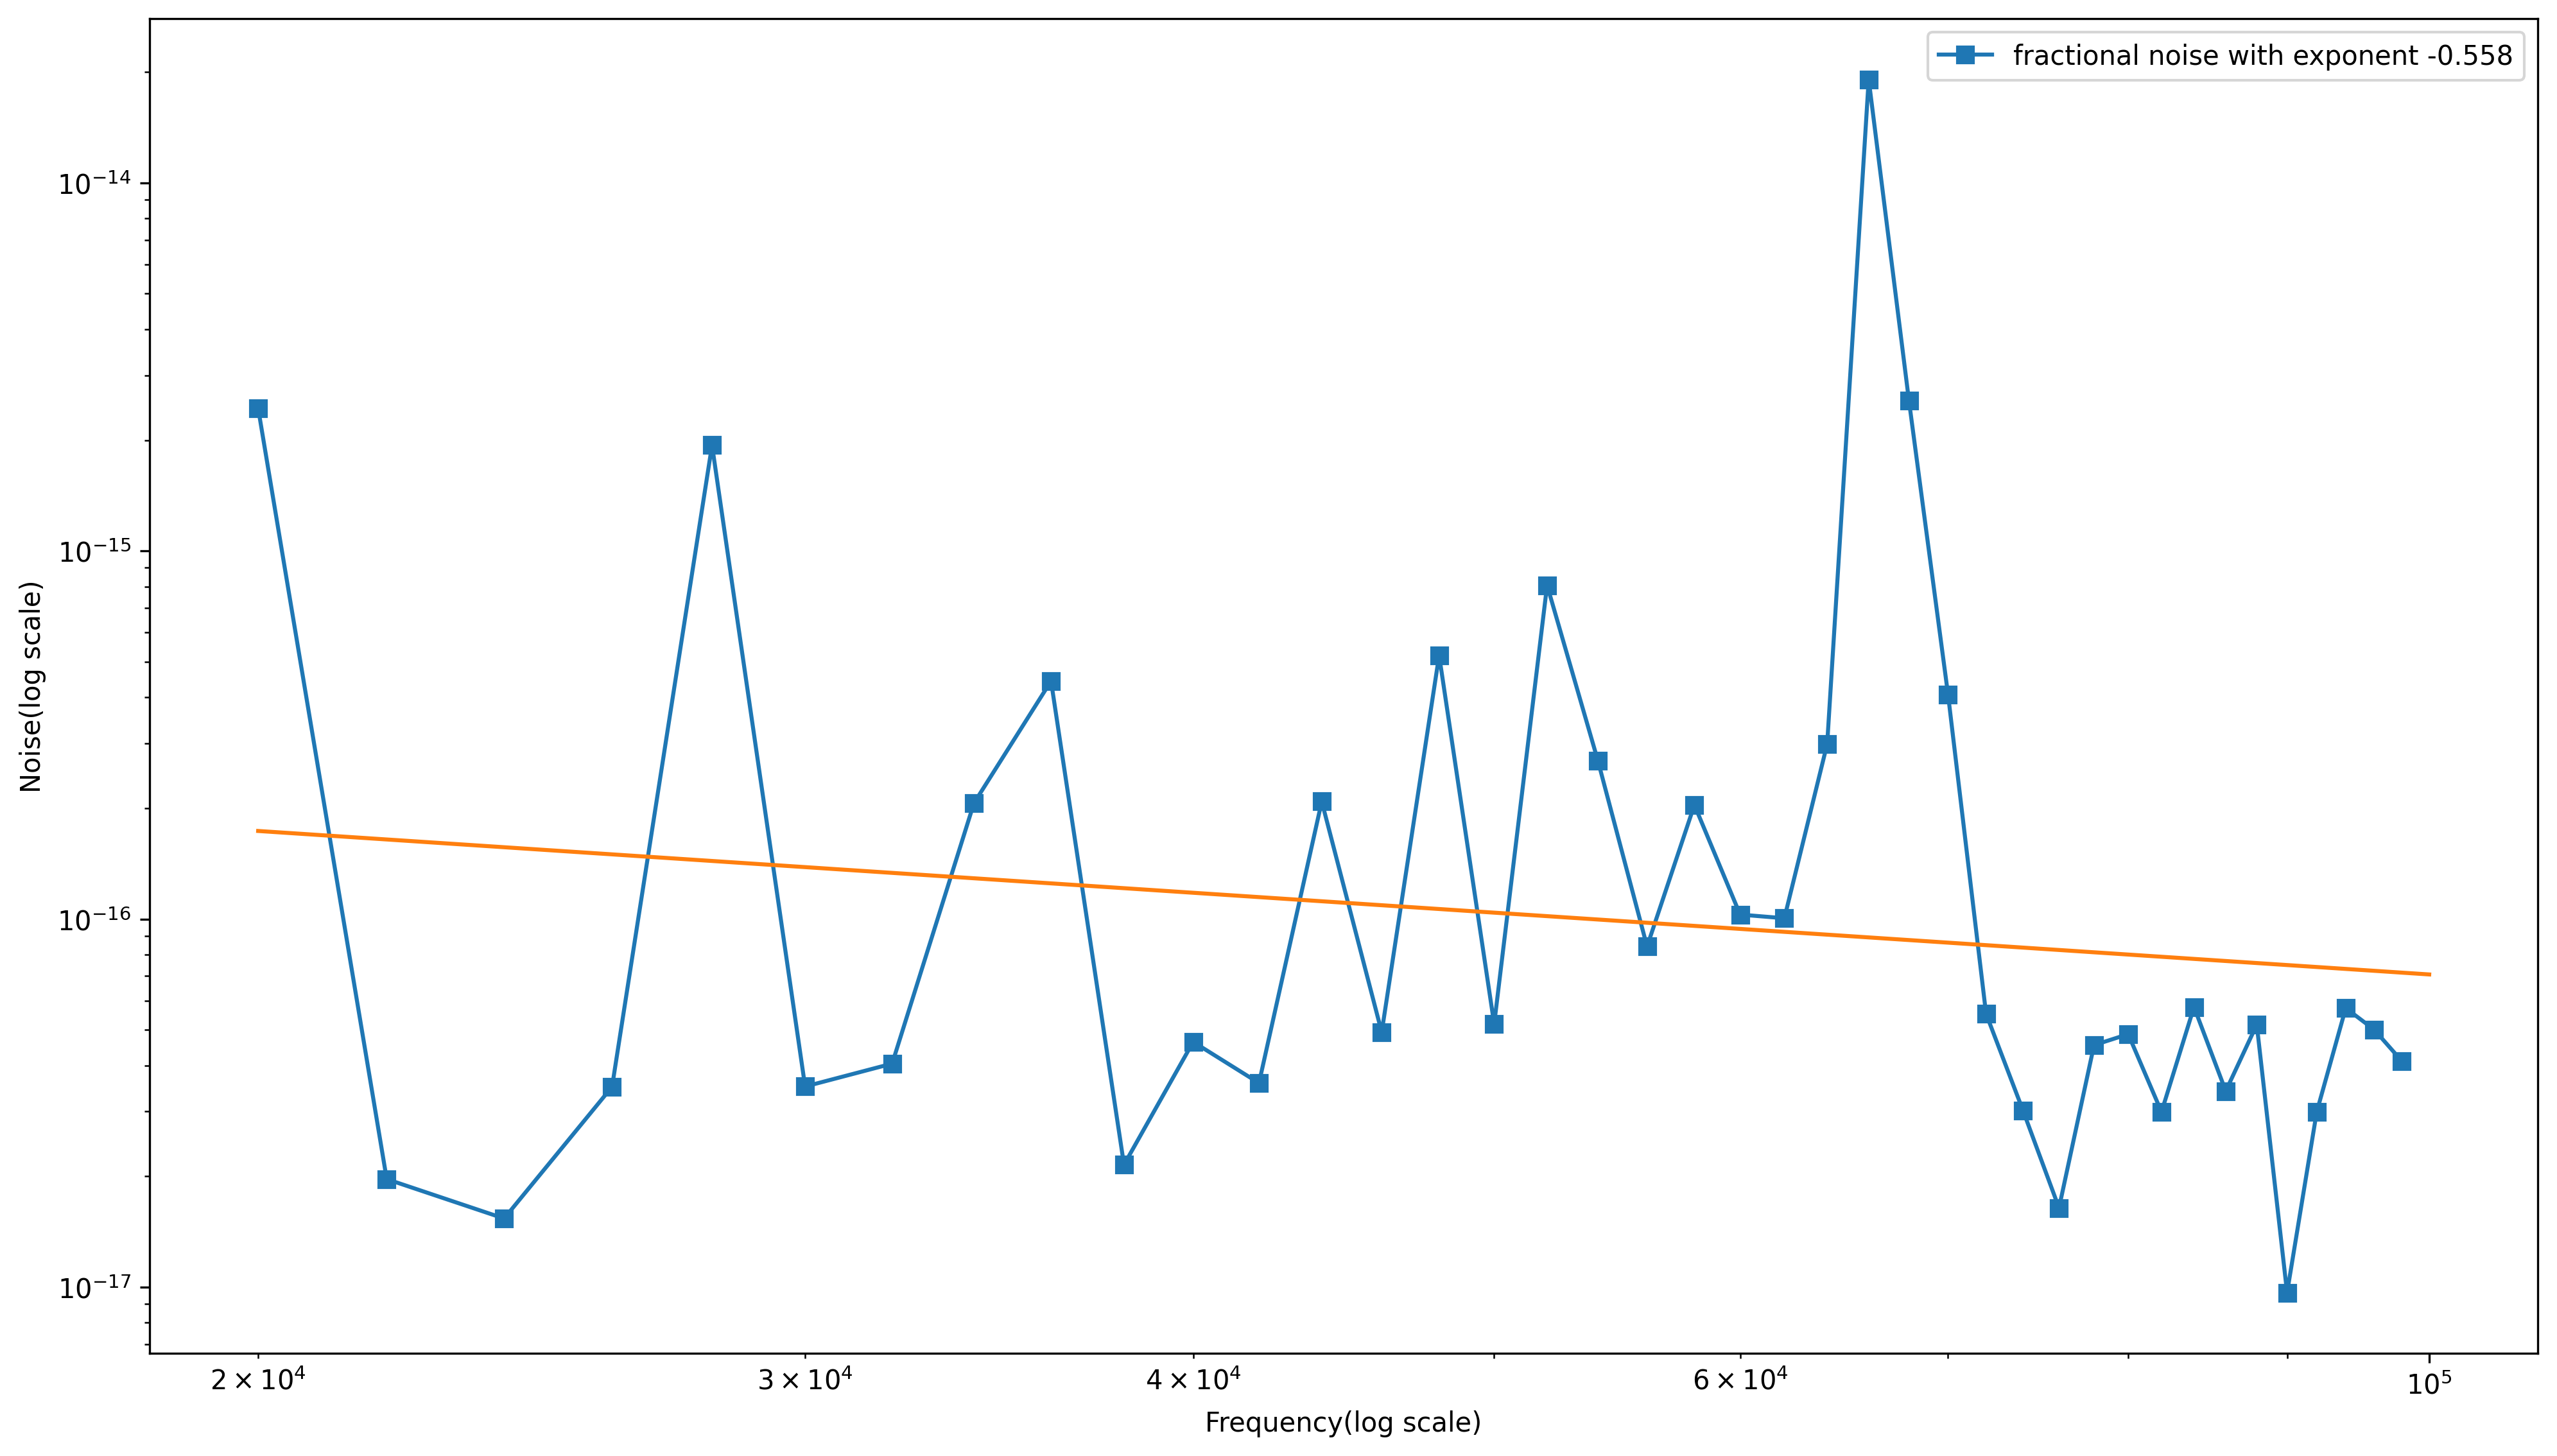

In [117]:
fig, axes = plt.subplots(1,1, dpi =300, figsize = (16,9))
fc_cutoff = -1
axes.set_xscale("log")
axes.set_yscale("log")
axes.plot(freqRange_coll[:fc_cutoff], (noiseX**2)[:fc_cutoff], marker = "s", label = f"fractional noise with exponent {params[0]:.3f}")
axes.legend()
yval = pow(freqRange_coll, params[0])*np.exp(params[-1])
axes.plot(freqRange_coll, yval)

# axes.plot(freqRange_coll, 1/freqRange_coll)
axes.set_xlabel("Frequency(log scale)")
axes.set_ylabel("Noise(log scale)")
# fig.savefig("flicker_noise_1.png", dpi=300)

In [99]:
freqRange_coll[-5]

np.float64(25251.0)

In [100]:
freqRange_coll[:fc_cutoff]

array([  437.,   656.,   985.,  1477.,  2216.,  3325.,  4987.,  7481.,
       11222., 16834., 25251., 37876., 56815., 85222.])